# Doubly Robust Models
Basically, different ensemble models that utilize a weight model to augment the outcome model.  

This notebook presents different combinations of mixing outcome and propensity models,  
but since the possible combination are a lot, it does not intend to show all of them.

In [1]:
%matplotlib inline
from sklearn.linear_model import LogisticRegression, LinearRegression
from causallib.datasets import load_nhefs
from causallib.estimation import IPW, Standardization, StratifiedStandardization
from causallib.estimation import AIPW, PropensityFeatureStandardization, WeightedStandardization
from causallib.evaluation import evaluate

#### Data:
The effect of quitting to smoke on weight loss.  
Data example is taken from [Hernan and Robins Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

In [2]:
data = load_nhefs()
data.X.join(data.a).join(data.y).head()

,age,race,sex,smokeintensity,smokeyrs,wt71,active_1,active_2,education_2,education_3,education_4,education_5,exercise_1,exercise_2,age^2,wt71^2,smokeintensity^2,smokeyrs^2,qsmk,wt82_71
0,42,1,0,30,29,79.04,0,0,0,0,0,0,0,1,1764,6247.3216,900,841,0,-10.093960
1,36,0,0,20,24,58.63,0,0,1,0,0,0,0,0,1296,3437.4769,400,576,0,2.604970
2,56,1,1,20,26,56.81,0,0,1,0,0,0,0,1,3136,3227.3761,400,676,0,9.414486
3,68,1,0,3,53,59.42,1,0,0,0,0,0,0,1,4624,3530.7364,9,2809,0,4.990117
4,40,0,0,20,19,87.09,1,0,1,0,0,0,1,0,1600,7584.6681,400,361,0,4.989251


## Vanilla Doubly Robust
Used for average outcomes.  
Its individual outcome estimation is directly its outcome model one's,  
but for population outcome, it corrects the observed outcome using the individual outcome prediction before taking weighted average.

In [3]:
ipw = IPW(LogisticRegression(solver="liblinear"), clip_min=0.05, clip_max=0.95)
std = StratifiedStandardization(LinearRegression())
dr = AIPW(std, ipw)
dr.fit(data.X, data.a, data.y)

AIPW(outcome_covariates=None, outcome_model=StratifiedStandardization(learner=LinearRegression()), overlap_weighting=False, predict_proba=False, weight_covariates=None,
     weight_model=IPW(clip_max=0.95, clip_min=0.05, use_stabilized=False, verbose=False,
    learner=LogisticRegression(solver='liblinear')))

Doubly-robust corrected population outcomes:

In [4]:
pop_outcome = dr.estimate_population_outcome(data.X, data.a, data.y)
pop_outcome

qsmk
0    1.761707
1    5.205193
dtype: float64

In [5]:
effect = dr.estimate_effect(pop_outcome[1], pop_outcome[0])
effect

diff    3.443486
dtype: float64

## Doubly Robust IP-Feature
Trains a weight model, and then use its output (predicted weights) as additional features to the outcome model.  

If possible (like in IPW) the entire weight-matrix (weight of each individual for each treatment value) is used,  
but usually, only a weight vector (according to the actual treatment assignment) is used.

In [6]:
ipw = IPW(LogisticRegression(solver="liblinear"))
std = Standardization(LinearRegression())
dr = PropensityFeatureStandardization(std, ipw)
dr.fit(data.X, data.a, data.y)

PropensityFeatureStandardization(feature_type=weight_vector, outcome_covariates=None, outcome_model=Standardization(encode_treatment=False, predict_proba=False,
                learner=LinearRegression()), predict_proba=False, weight_covariates=None,
                                 weight_model=IPW(clip_max=None, clip_min=None, use_stabilized=False, verbose=False,
    learner=LogisticRegression(solver='liblinear')))

In [7]:
ind_outcomes = dr.estimate_individual_outcome(data.X, data.a)
ind_outcomes.head()

qsmk,0,1
0,4.210930,7.323565
1,6.282489,9.395125
2,1.944428,5.057063
3,-4.113043,-1.000407
4,2.281084,5.393720


In [8]:
effect = dr.estimate_effect(ind_outcomes[1], ind_outcomes[0],
                            effect_types=["diff", "ratio"])
effect

diff     3.112635
ratio    2.694151
dtype: float64

## Doubly Robust Joffe
This uses an importance sampling using the estimated weights.  

On the first step weight model is trained and used to predict weights.  
These predicted weights are then provided as `sample_weights` to the outcome model.

In [9]:
ipw = IPW(LogisticRegression(solver="liblinear"))
std = Standardization(LinearRegression())
dr = WeightedStandardization(std, ipw)
dr.fit(data.X, data.a, data.y)

WeightedStandardization(outcome_covariates=None, outcome_model=Standardization(encode_treatment=False, predict_proba=False,
                learner=LinearRegression()), predict_proba=False, weight_covariates=None,
                        weight_model=IPW(clip_max=None, clip_min=None, use_stabilized=False, verbose=False,
    learner=LogisticRegression(solver='liblinear')))

In [10]:
ind_outcomes = dr.estimate_individual_outcome(data.X, data.a)
ind_outcomes.head()

qsmk,0,1
0,4.190402,7.661444
1,6.963815,10.434857
2,3.298580,6.769622
3,-4.788300,-1.317258
4,3.150589,6.621631


In [11]:
pop_outcome = dr.estimate_population_outcome(data.X, data.a)
pop_outcome

qsmk
0    1.757128
1    5.228170
dtype: float64

In [12]:
effect = dr.estimate_effect(pop_outcome[1], pop_outcome[0])
effect

diff    3.471042
dtype: float64

## Confounders, Instruments and Effect Modifiers
On general there are three main types of covariates in a graphical causal model:
1. Confounders: variables that affect both the outcome and treatment
2. Instruments: variables that affect the treatment assignment but not the outcome.
3. Effect mods: variables that affect the outcome but not the treatment assignment

For a Doubly Robust model that holds both outcome model and weight (treatment assignment prediction) model,  
These can specified by a list of covariates `outcome_covariates` and `weight_covariates`,  
which their intersection correspond to _confounders_ and their symmetric difference are the effect modifiers and instruments, respectively.

In [13]:
# Say smoke quitting does not depend on your weight and on your age
weight_covariates = [col for col in data.X.columns 
                     if not col.startswith("wt") and not col.startswith("age")]
ipw = IPW(LogisticRegression(solver="liblinear"))
std = Standardization(LinearRegression())
dr = PropensityFeatureStandardization(std, ipw, 
                                      weight_covariates=weight_covariates)
# By not specifying `outcome_covariates` the model will use all covariates
dr.fit(data.X, data.a, data.y);

In [14]:
pop_outcome = dr.estimate_population_outcome(data.X, data.a)
pop_outcome

qsmk
0    1.987433
1    4.516607
dtype: float64

In [15]:
dr.estimate_effect(pop_outcome[1], pop_outcome[0])

diff    2.529174
dtype: float64

## Refitting weight model
The doubly robust model has an outcome model and a weight model.  
As noted, the weight model is used to augment the outcome model,  
implying the outcome model is dependent on the weight model but not vice versa.  

This allows us to save computation power when having a multi-outcome problem.  
Since the weight model will be the same throughout, there's no need to refit it every time the model is trained for a different outcome.

The `refit_weight_model` can be turned off by providing `False`.  
This way if provided with an already fitted weight model, it won't be refitted upon repeating `fit()` calls on the Doubly Robust object.

In [16]:
ipw = IPW(LogisticRegression(solver="liblinear"), clip_min=0.05, clip_max=0.95)
std = Standardization(LinearRegression(), encode_treatment=True)
dr = AIPW(std, ipw)

Let's imagine we have different outcomes, `y1` and `y2`.
Calling the first fit with whatever outcome will fit the weight model, as it is not fitted yet.  
However, on the second call, it will not be fitted as we provide `refit_weight_model=False`.

In [17]:
y1, y2 = data.y, data.y
dr.fit(data.X, data.a, y1)  # weight model is fitted since it is not yet fitted
dr.fit(data.X, data.a, y2)  # weight model is fitted since we did not specify otherwise
dr.fit(data.X, data.a, y1, refit_weight_model=False);  # weight model is not fitted.

## Evaluation
Evaluation is performed for the inner outcome model and weight model separately

In [18]:
ipw = IPW(LogisticRegression(solver="liblinear"))
std = Standardization(LinearRegression())
dr = PropensityFeatureStandardization(std, ipw)
dr.fit(data.X, data.a, data.y);

,accuracy,precision,recall,f1,roc_auc,avg_precision,hinge,matthews,0_1,brier,confusion_matrix,roc_curve,pr_curve
0,0.749042,0.613636,0.066998,0.120805,0.660555,0.400766,1.10319,0.138572,0.250958,0.179105,"[[1146, 17], [376, 27]]","([0.0, 0.0, 0.0, 0.0008598452278589854, 0.0008...","([0.25767263427109977, 0.2571976967370441, 0.2..."


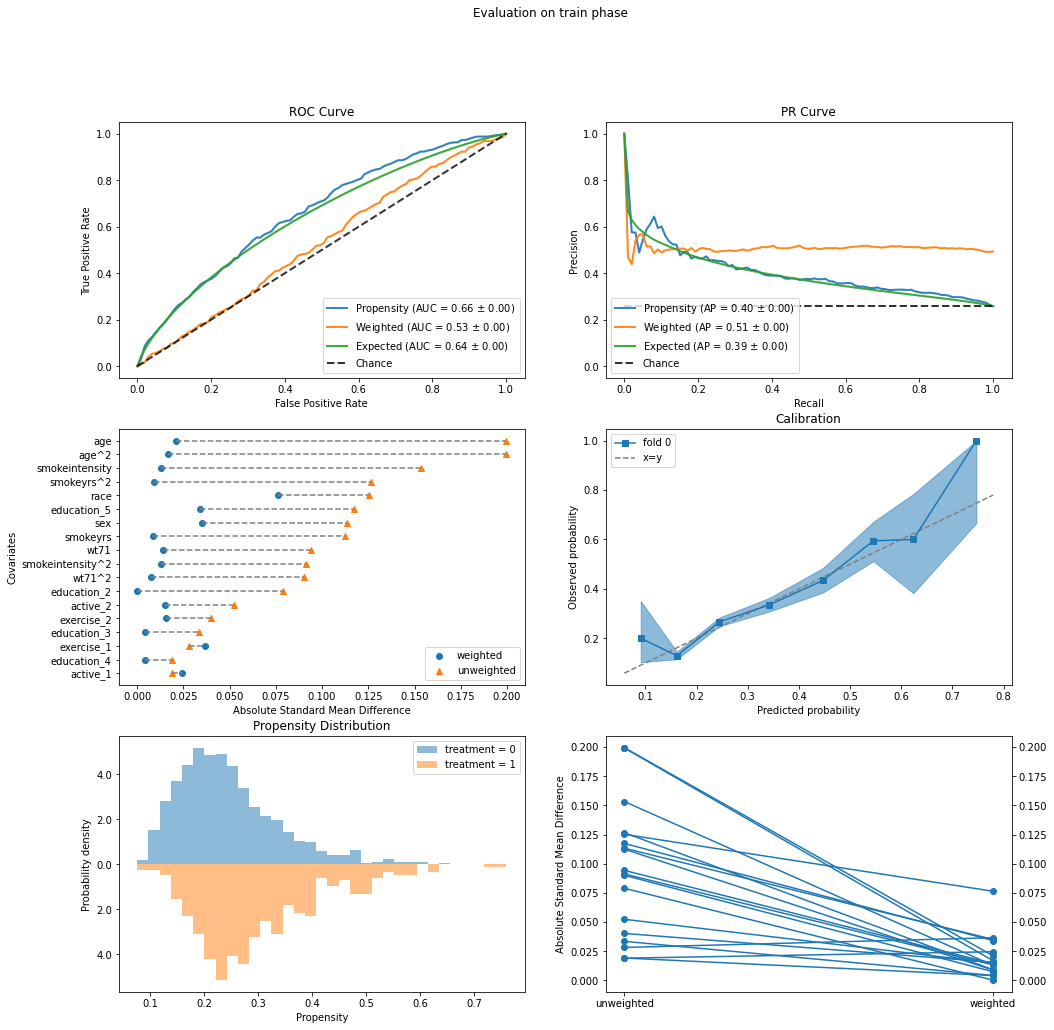

In [19]:
results = evaluate(dr.weight_model, data.X, data.a, data.y)
results.plot_all()
results.evaluated_metrics.prediction_scores

,expvar,mae,mse,mdae,r2
model_strata,,,,,
actual,0.147487,5.278826,52.901286,4.039940,0.147487
0,0.125392,4.999575,48.489150,3.806782,0.125392
1,0.140264,6.084701,65.634076,4.552075,0.140264


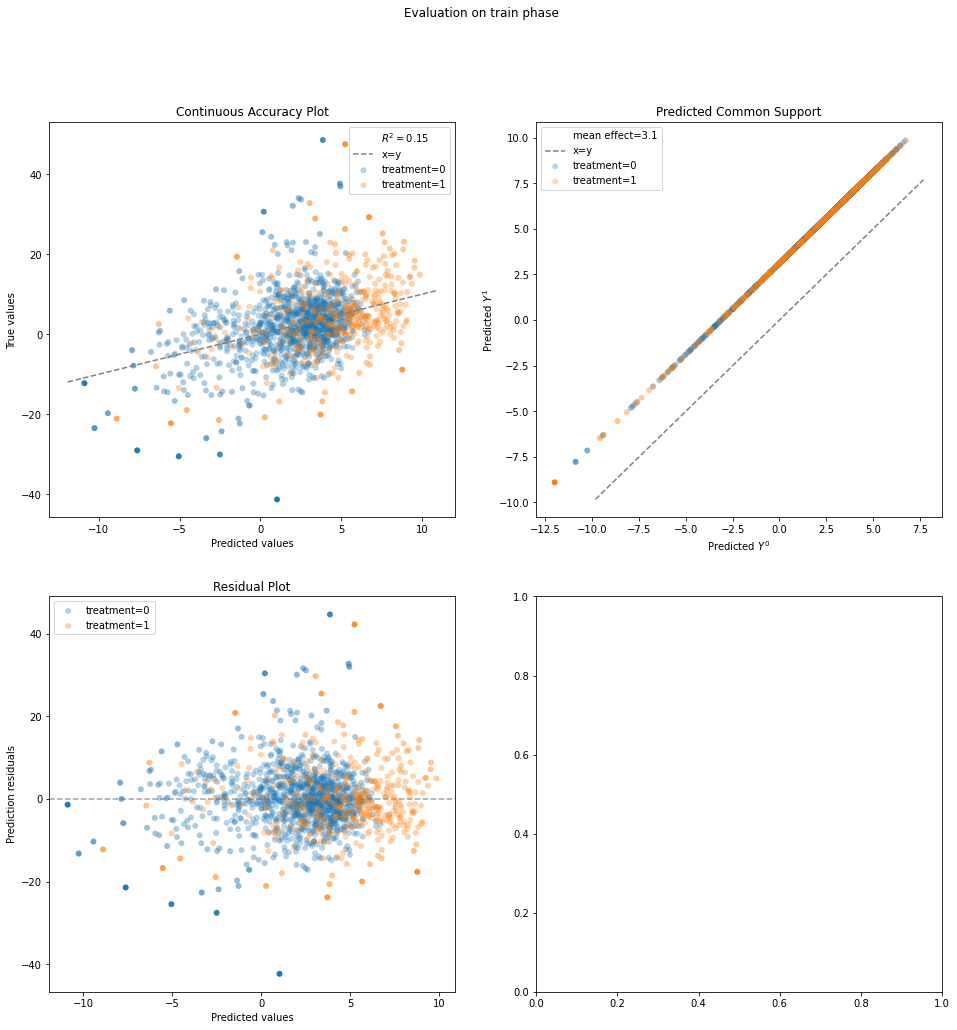

In [20]:
results = evaluate(dr, data.X, data.a, data.y)
results.plot_all()                                        
results.evaluated_metrics